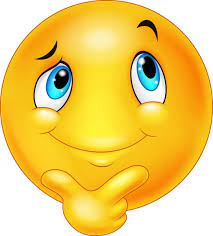

##### **Good luck with taking your exam. Keep working and make your dreams all come true. Seeing the results of all of your hard work will make this struggle worth it. We’re all thinking of you.** 
<b><font color='blue'>AI-PRO Spark Team ITI</font></b>

# NLP Using PySpark

## Objective:
- The objective from this project is to create a <b>Spam filter using NaiveBayes classifier</b>.
- It is required to obtain <b>f1_scored > 0.9</b>.
- We'll use a dataset from UCI Repository. SMS Spam Detection: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
- Data is also provided for you in the assignment (you do not have to download it).

## To perform this task follow the following guiding steps:

### Create a spark session and import the required libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as fun
import numpy as np

In [5]:
spark = SparkSession.builder.appName("spamFilter").getOrCreate()

22/07/24 21:23:10 WARN Utils: Your hostname, sam-pc resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface wlp2s0)
22/07/24 21:23:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/24 21:23:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read the readme file to learn more about the data

### Read the data into a DataFrame

In [9]:
data_df = spark.read.csv("SMSSpamCollection", sep='\t', inferSchema=True, header=False)

### Print the schema

In [12]:
data_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



### Rename the first column to 'class' and second column to 'text'

In [ ]:
data_df = data_df.withColumnRenamed('_c0', 'class')
data_df = data_df.withColumnRenamed('_c1', 'text')

In [5]:
data_df.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)



### Show the first 10 rows from the dataframe
- Show once with truncate=True and once with truncate=False

In [16]:
data_df.show(10, truncate=True)

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
+-----+--------------------+
only showing top 10 rows



In [17]:
data_df.show(10, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|class|text                                                                                                                                                            |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ham  |Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                 |
|ham  |Ok lar... Joking wif u oni...                                                                                                                                   |
|spam |Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075o

## Clean and Prepare the Data

### Create a new feature column contains the length of the text column

In [27]:
df_cleaned = data_df.withColumn("length", fun.length(data_df['text']))

### Show the new dataframe

In [28]:
df_cleaned.show()

+-----+--------------------+------+
|class|                text|length|
+-----+--------------------+------+
|  ham|Go until jurong p...|   111|
|  ham|Ok lar... Joking ...|    29|
| spam|Free entry in 2 a...|   155|
|  ham|U dun say so earl...|    49|
|  ham|Nah I don't think...|    61|
| spam|FreeMsg Hey there...|   147|
|  ham|Even my brother i...|    77|
|  ham|As per your reque...|   160|
| spam|WINNER!! As a val...|   157|
| spam|Had your mobile 1...|   154|
|  ham|I'm gonna be home...|   109|
| spam|SIX chances to wi...|   136|
| spam|URGENT! You have ...|   155|
|  ham|I've been searchi...|   196|
|  ham|I HAVE A DATE ON ...|    35|
| spam|XXXMobileMovieClu...|   149|
|  ham|Oh k...i'm watchi...|    26|
|  ham|Eh u remember how...|    81|
|  ham|Fine if thats th...|    56|
| spam|England v Macedon...|   155|
+-----+--------------------+------+
only showing top 20 rows



### Get the average text length for each class (give alias name to the average length column)

In [141]:
df_cleaned.groupBy('class').avg().withColumnRenamed("avg(length)", "Avg. Length").show()

df_cleaned.groupBy('class').agg(fun.round(fun.avg("length"), 2).alias("Avg. Length")).show()

df_cleaned.groupBy('class').avg().select("class", fun.col("avg(length)").alias("Avg. Length")).show()

+-----+-----------------+
|class|      Avg. Length|
+-----+-----------------+
|  ham|71.45431945307645|
| spam|138.6706827309237|
+-----+-----------------+

+-----+-----------+
|class|Avg. Length|
+-----+-----------+
|  ham|      71.45|
| spam|     138.67|
+-----+-----------+

+-----+-----------------+
|class|      Avg. Length|
+-----+-----------------+
|  ham|71.45431945307645|
| spam|138.6706827309237|
+-----+-----------------+



## Feature Transformations

### In this part you transform you raw text in to tf_idf model :
- For more information about TF-IDF check the following link: <b>(Not needed for the test)</b>
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### Perform the following steps to obtain TF-IDF:
1. Import the required transformers/estimators for the subsequent steps.
2. Create a <b>Tokenizer</b> from the text column.
3. Create a <b>StopWordsRemover</b> to remove the <b>stop words</b> from the column obtained from the <b>Tokenizer</b>.
4. Create a <b>CountVectorizer</b> after removing the <b>stop words</b>.
5. Create the <b>TF-IDF</b> from the <b>CountVectorizer</b>.

In [81]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler

In [91]:
# First Stage Tokenize Text
# transform words to lower and sentence arrays of words
tokenized = Tokenizer(inputCol='text', outputCol='token_text')

In [92]:
# Second Stage Remove StopWords from Text
no_stopwords = StopWordsRemover(inputCol='token_text', outputCol='removed_stopwords')

In [93]:
# Third Stage CountVectorized
c_vectorized = CountVectorizer(inputCol='removed_stopwords', outputCol='count_vector')

In [182]:
# Fourth Stage IDF
tf_idf = IDF(inputCol = 'count_vector', outputCol = 'tf_idf')

- Convert the <b>class column</b> to index using <b>StringIndexer</b>
- Create feature column from the <b>TF-IDF</b> and <b>lenght</b> columns.

In [188]:
# Fifth Stage Indexer
class_indexer = StringIndexer(inputCol = 'class', outputCol = 'label')

In [189]:
# Fifth Stage VectorAssembler
vec_assembler = VectorAssembler(inputCols = ['tf_idf', 'length'], outputCol = 'features')

## The Model
- Create a <b>NaiveBayes</b> classifier with the default parameters.

In [190]:
from pyspark.ml.classification import NaiveBayes

naive_model = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")

## Pipeline
### Create a pipeline model contains all the steps starting from the Tokenizer to the NaiveBays classifier.

In [196]:
from pyspark.ml.pipeline import Pipeline

In [198]:
all_stages = [class_indexer, tokenized, no_stopwords, c_vectorized, tf_idf, vec_assembler, naive_model]
pipeline = Pipeline(stages=all_stages)

### Split your data to trian and test data with ratios 0.7 and 0.3 respectively.

In [199]:
(train_data, test_data) = df_cleaned.randomSplit(weights=[0.7, 0.3], seed=222)

### Fit your Pipeline model to the training data

In [200]:
pipeline_fitted = pipeline.fit(train_data)

In [201]:
pipeline_transform_train = pipeline_fitted.transform(train_data)

### Perform predictions on tests dataframe

In [202]:
pipeline_transform_test = pipeline_fitted.transform(test_data)

### Print the schema of the prediction dataframe

In [203]:
pipeline_transform_test.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- token_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- removed_stopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vector: vector (nullable = true)
 |-- tf_idf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



## Model Evaluation
- Use <b>MulticlassClassificationEvaluator</b> to calculate the <b>f1_score</b>.

In [204]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()

In [221]:
# Prediction accuracy on train data
print(f"""
        train data (f1_score): {evaluator.setMetricName('f1').evaluate(pipeline_transform_train)}\n
        train data (accuracy): {evaluator.setMetricName('accuracy').evaluate(pipeline_transform_train)}
""")

22/07/25 00:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1115.1 KiB
22/07/25 00:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1115.1 KiB



        train data (f1_score): 0.9961788340213071

        train data (accuracy): 0.9961597542242704



In [220]:
# Prediction accuracy on test data
print(f"""
        test data (f1_score): {evaluator.setMetricName('f1').evaluate(pipeline_transform_test)}\n
        test data (accuracy): {evaluator.setMetricName('accuracy').evaluate(pipeline_transform_test)}
""")

22/07/25 00:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB
22/07/25 00:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB



        test data (f1_score): 0.9807751125009001

        test data (accuracy): 0.9808153477218226



# GOOD LUCK
<b><font color='GREEN'>AI-PRO Spark Team ITI</font></b>

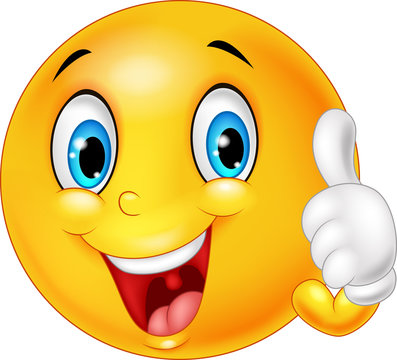